In [6]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import layers, models, Input
import tensorflow as tf


dataset_path = "data"
image_size = (192, 192)
unet_model_path = "Models/SegmentationModelUnet/model.keras"

dataset_path = "data"

print('Our dataset = ')
print(os.listdir(dataset_path))

Our dataset = 
['Grupo_0', 'Grupo_1', '.DS_Store', 'Grupo_4', 'Grupo_3', 'Grupo_2', 'Grupo_5']


In [7]:
def load_images_from_folder(folder_path, max_depth = 5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue
        

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, image_size)
                            img = img/255
                            images.append(img)
                            labels.append(1 if file[6]!='0' else 0)
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)

        else:
            del dirs[:]
    
    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")

    return np.array(images), np.array(labels), np.array(names)

images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")

Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the data folder with shape (2820, 192, 192)


In [8]:
#Removing Bias towards Alcohol Detection

#Splitting Classes
alcoholicClass = [images[i] for i in range(len(labels)) if labels[i] == 1]
nonAlcoholicClass = [images[i] for i in range(len(labels)) if labels[i] == 0]

alcoholicClass = np.array(alcoholicClass)
nonAlcoholicClass = np.array(nonAlcoholicClass)

#Data Generator Setup
datagen = ImageDataGenerator(
    rotation_range=4,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.025,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Augmentation:

n1 = len(nonAlcoholicClass)
n2 = len(alcoholicClass)
target_size = n2
augmentation_needed = target_size - n1

print(f'Number of samples in Class 1 (FFD): {n1}')
print(f'Number of samples in Class 2 (Alcoholic): {n2}')
print(f'Augmenting {augmentation_needed} images for Class 1 to match Class 2.')

augmented_images = []
for i in range(augmentation_needed):
    img = nonAlcoholicClass[i % n1]  
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)  
    augmented_img = next(datagen.flow(img, batch_size=1))[0]
    augmented_img = np.squeeze(augmented_img, axis=-1)
    augmented_img = augmented_img.astype(int)
    augmented_images.append(augmented_img)

augmented_images = np.array(augmented_images)

concagtedClassNon = np.concatenate([nonAlcoholicClass, augmented_images], axis=0)

print(f'New size of Class 1: {len(alcoholicClass)}')
print(f'New size of Class 2: {len(concagtedClassNon)}')

Number of samples in Class 1 (FFD): 580
Number of samples in Class 2 (Alcoholic): 2240
Augmenting 1660 images for Class 1 to match Class 2.
New size of Class 1: 2240
New size of Class 2: 2240


In [9]:
alcoholic_labels = np.ones(len(alcoholicClass))
nonAlcoholic_labels = np.zeros(len(concagtedClassNon))

images = np.concatenate([alcoholicClass, concagtedClassNon], axis=0)
labels = np.concatenate([alcoholic_labels, nonAlcoholic_labels], axis=0)

shuffled_indices = np.random.permutation(len(images))
images = images[shuffled_indices]
labels = labels[shuffled_indices]

print(f"Total number of images after augmentation: {len(images)}")
print(f"Shape of final images array: {images.shape}")
print(f"Shape of final labels array: {labels.shape}")

Total number of images after augmentation: 4480
Shape of final images array: (4480, 192, 192)
Shape of final labels array: (4480,)


In [10]:
#Segmenting Images
print(images.shape)

unet_model = tf.keras.models.load_model(unet_model_path)
segmentedImages = unet_model.predict(images)

print(segmentedImages.shape)

(4480, 192, 192)
140/140 ━━━━━━━━━━━━━━━━━━━━ 125s 895ms/step
(4480, 192, 192, 1)


In [11]:
images = np.expand_dims(images, -1)
print(f"Images shape changed to: {images.shape}")

Images shape changed to: (4480, 192, 192, 1)


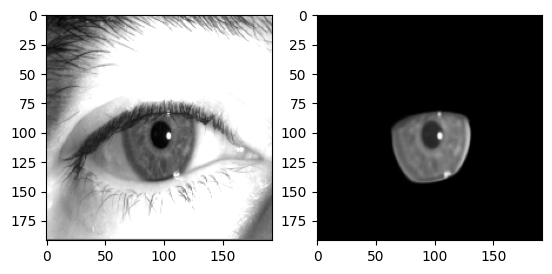

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(images[90], cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(segmentedImages[90], cmap='gray')
plt.show()

In [13]:
def attention_module(x):
    # Simple attention block (SE-style)
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(x.shape[-1] // 8, activation='relu')(se)
    se = layers.Dense(x.shape[-1], activation='sigmoid')(se)
    se = layers.Reshape((1, 1, x.shape[-1]))(se)
    return layers.Multiply()([x, se])

def feature_extraction_branch(input_shape):
    inp = Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = attention_module(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    return models.Model(inp, x)

def fusion_classification_model(input_shape):
    input1 = Input(shape=input_shape, name='raw_input')
    input2 = Input(shape=input_shape, name='seg_input')

    branch = feature_extraction_branch(input_shape)

    feat1 = branch(input1)
    feat2 = branch(input2)

    # Fusion
    fused = layers.Concatenate()([feat1, feat2])
    fused = layers.Dense(64, activation='relu')(fused)
    fused = layers.Dropout(0.5)(fused)
    output = layers.Dense(1, activation='sigmoid')(fused)

    return models.Model(inputs=[input1, input2], outputs=output)


In [ ]:
def attention_module(x):
    # Simple attention block (SE-style)
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(x.shape[-1] // 8, activation='relu')(se)
    se = layers.Dense(x.shape[-1], activation='sigmoid')(se)
    se = layers.Reshape((1, 1, x.shape[-1]))(se)
    return layers.Multiply()([x, se])

def feature_extraction_branch(input_shape):
    inp = Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = attention_module(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    return models.Model(inp, x)

def fusion_classification_model(input_shape):
    input1 = Input(shape=input_shape, name='raw_input')
    input2 = Input(shape=input_shape, name='seg_input')

    branch = feature_extraction_branch(input_shape)

    feat1 = branch(input1)
    feat2 = branch(input2)

    # Fusion
    fused = layers.Concatenate()([feat1, feat2])
    fused = layers.Dense(64, activation='relu')(fused)
    fused = layers.Dropout(0.5)(fused)
    output = layers.Dense(1, activation='sigmoid')(fused)

    return models.Model(inputs=[input1, input2], outputs=output)


In [14]:
print(labels.shape)
lables = labels.astype("float32").reshape(-1, 1)
print(lables.shape)

(4480,)
(4480, 1)


In [15]:
images_train, images_test, segImages_train, segImages_test, labels_train, labels_test = train_test_split(images, segmentedImages, labels, test_size=0.7, random_state=23)

In [16]:
model = fusion_classification_model((192, 192, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.fit([images_train, segImages_train], labels_train, epochs=10, batch_size=32)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.6957 - loss: 0.6043
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.8733 - loss: 0.3290
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.8702 - loss: 0.3247
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.8705 - loss: 0.3349
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.8871 - loss: 0.2954
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.9042 - loss: 0.2754
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.8800 - loss: 0.3211
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.8856 - loss: 0.3104
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.8755 - loss: 0.3164
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.8867 - loss: 0.3034


In [18]:
loss, accuracy = model.evaluate([images_test, segImages_test], labels_test)
print(f"CNN Test Accuracy: {accuracy * 100:.2f}%")

predictions = model.predict([images_test, segImages_test])
predicted_classes = (predictions > 0.5).astype(int).flatten()

report = classification_report(labels_test.flatten(), predicted_classes, target_names=['Fit for Duty', 'Alcoholic'])
print(report)

print(f'Overall Accuracy: {accuracy * 100:.2f}%')

98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8660 - loss: 0.3293
CNN Test Accuracy: 86.48%
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step
              precision    recall  f1-score   support

Fit for Duty       1.00      0.73      0.85      1581
   Alcoholic       0.79      1.00      0.88      1555

    accuracy                           0.86      3136
   macro avg       0.89      0.87      0.86      3136
weighted avg       0.89      0.86      0.86      3136

Overall Accuracy: 86.48%
